# Linear SDOF PINN - forward modeller

## Problem overview

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \ddot{x} + c \dot{x} + kx = F_x~, \qquad \ddot{x} + \tilde{c} \dot{x} + \tilde{k}x = \tilde{F}_x~, \qquad \tilde{\bullet} = \frac{\bullet}{m}
$$
with the initial conditions and forcing,
$$
x(0) = 10\mathrm{mm}~~,~~\dot{x}(0) = 0, \qquad F_x = F_0\sin(\omega_t)
$$
<!-- This has the following exact solution:
$$
x(t) = e^{-\zeta \omega_n t} \left[ x_0 \cos(\omega_dt) + \left( \frac{\dot{x}_0+\zeta \omega_nx_0}{\omega_d} \right)\sin(\omega_dt) \right], \qquad \omega_d = \omega_n\sqrt{1-\zeta^2}
$$
where,
$$
\omega_n = \sqrt{\frac{k}{m}}=\sqrt{\tilde{k}}, \qquad \zeta=\frac{c}{2m\omega_n} = \frac{\tilde{c}}{2\sqrt{\tilde{k}}}
$$ -->

## State Space Formulation
$$ \dot{\mathbf{\tau}}(t) = \mathbf{A}\mathbf{\tau}(t) + \mathbf{B}\mathbf{f}(t) $$
where,
$$  \mathbf{\tau}(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}, \quad
    \mathbf{A} = \begin{bmatrix} 0 & 1 \\ -m^{-1}k & -m^{-1}c \end{bmatrix}, \quad
    \mathbf{B} = \begin{bmatrix} 0 \\ m^{-1} \end{bmatrix} $$
And the measurement vector is,
$$ \mathbf{y}(t) = \begin{bmatrix} S_d & 0 \\ 0 & S_a \end{bmatrix} \begin{bmatrix} x(t) \\ \ddot{x}(t) \end{bmatrix} $$

In [14]:
from sdof_pinn import sdof_forced_pinn, normalise
from sdof_oscillators import forcing_func

import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set forcing conditions and collocation points

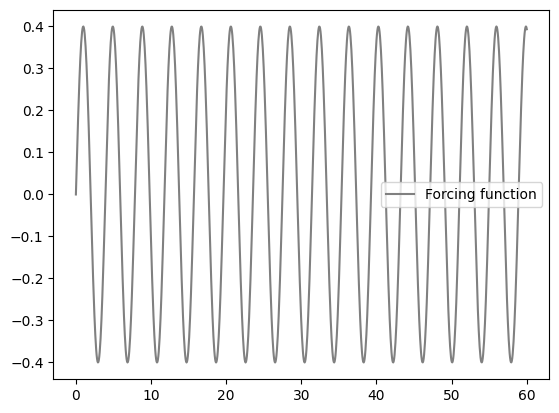

In [18]:
nt = 1024
F0 = 0.4  # N
w = 1.6  # rad/s
t = torch.linspace(0,60,nt).view(-1,1)

F = forcing_func(F0, w, t)

c_tild = torch.tensor(0.1)
k_tild = torch.tensor(2.0)

plt.figure()
plt.plot(t, F, color="gray", label="Forcing function")
plt.legend()

Normalise

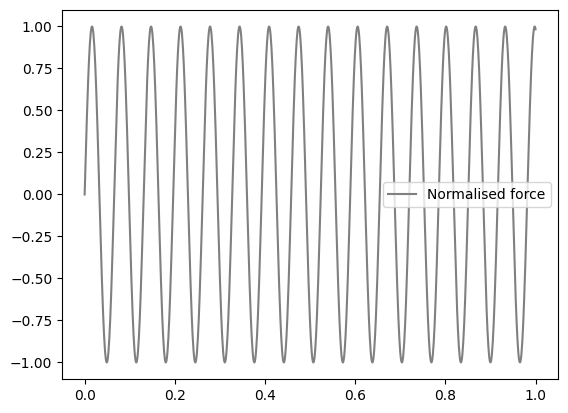

In [19]:
t_hat, alpha_t = normalise(t, "range")
F_hat, alpha_F = normalise(F, "range")
alphas = {
    "t" : alpha_t,
    "F" : alpha_F
}

plt.figure()
plt.plot(t_hat, F_hat, color="gray", label="Normalised force")
plt.legend()

Create arbitrary data for observation which is unused

In [20]:
t_data = torch.linspace(0,1,20).view(-1,1)
x_data = torch.linspace(0,1,20).view(-1,1)

## PINN

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) = \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{ode} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} - \eta\hat{F} \rangle _{\Omega_d}
$$
where,
$$ 
\mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 
$$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^{-1}, \alpha_F^{-1}
$$

 28%|██▊       | 56499/200000 [04:20<11:02, 216.63it/s]


KeyboardInterrupt: 

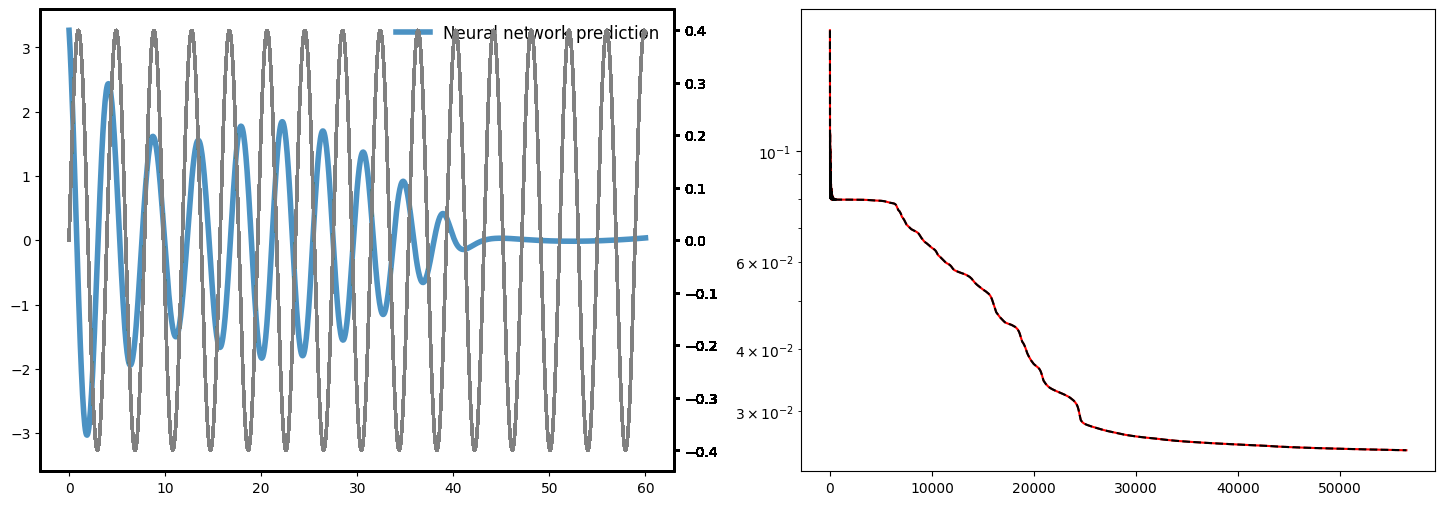

In [22]:
def plot_result(ax, tpred, xpred, force, alphas):
    ax.cla()
    # ax.plot(t_hat*alphas["t"], x_hat*alphas["x"], color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    ax.plot(tpred*alphas["t"], xpred*alphas["x"], color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    ax2 = ax.twinx()
    ax2.plot(tpred*alphas["t"], force*alphas["F"], color="grey", linewidth=2, alpha=0.8, label="Forcing")
    # ax.scatter(t_data*alphas["t"], x_data*alphas["x"], s=60, color="tab:orange", alpha=0.4, label='Training data')
    ax.legend(frameon=False, fontsize="large")
    xL = torch.amax(t_hat)*alphas["t"]
    yL = torch.amax(torch.abs(xpred))*alphas["x"]
    ax.set_xlim(-0.05*xL, 1.05*xL)
    ax.set_ylim(-1.1*yL, 1.1*yL)

def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,0],'b',label="Observation loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,1],'r',label="Physics loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,2],'k--',label="Total loss")
    ax.set_yscale('log')

alpha_c = c_tild*10
alpha_k = k_tild*10
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "t" : alpha_t,
    "x" : 1.0,
    "F" : alpha_F
}

torch.manual_seed(123)
pi_model = sdof_forced_pinn(
    N_INPUT = 1,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 2
    )

# set linear system
pi_model.nonlinearity("lin_osc")

# set physical parameters as either constant or variable to be optimised over
pi_model.set_phys_params(params={"k":k_tild,"c":c_tild}, par_type="constant")
# pi_model.set_phys_params(params={"k":1.0,"c":1.0}, par_type="variable")

# set normalisation parameters
pi_model.set_norm_params(alphas, 1.0)

# set forcing function
pi_model.set_forcing(F_hat)

ntp = nt  # number of collocation points
t_physics = torch.linspace(0, torch.max(t_hat), ntp).view(-1,1).requires_grad_()

epochs = int(200e3)
betas = (0.99,0.999)
optimizer = torch.optim.Adam(pi_model.parameters(),lr=2e-3,betas=betas)

fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
loss_hist=[]
lambds = {
    'obs' : torch.tensor(0.0),
    'ode' : torch.tensor(1.0)
}

for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    loss, losses = pi_model.loss_func(t_physics, t_data, x_data, lambds)

    loss_hist.append([losses[0].item(), losses[1].item(), loss.item()])
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i+1) % 500 == 0: 
        
        xpred = pi_model(t_physics).detach()
        
        plot_result(axs[0], t_physics.detach(), xpred, F_hat, alphas)

        plot_joint_loss_hist(axs[1],np.array(loss_hist))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        match pi_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k']))

display.clear_output()
match pi_model.param_type:
            case "constant":
                tqdma.write("Epochs : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epochs : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k']))